# Extreme Rainfall

In [6]:
import sys

import os.path as op
import numpy as np
import pandas as pd

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.plotting import plot_bar_probs
from ind_setup.colors import get_df_col, plotting_style

sys.path.append("../../../functions")
from data_downloaders import GHCN
plotting_style()

In [7]:
country = 'Palau'
vars_interest = ['PRCP']

## Get Data

In [8]:
update_data = False
path_data = "../../../data"

In [9]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

## Using Koror Station

In [10]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_prcp = GHCN.extract_dict_data_var(GHCND_dir, 'PRCP', df_country_stations.loc[df_country_stations['ID'] == id])[0]
    data = dict_prcp[0]['data']#.dropna()
    data.to_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))
else:
    data = pd.read_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))

In [11]:
data = data.groupby(data.index.year).filter(lambda x: len(x) >= 300).dropna()

In [12]:
datag = data.groupby(data.index.year).max()
datag.index = pd.to_datetime(datag.index, format = '%Y')


In [13]:
dict_plot = [{'data' : datag, 'var' : 'PRCP', 'ax' : 1, 'label':f'Annual Maxima'},]

In [14]:
plot_timeseries_interactive(dict_plot, trendline = True, figsize = (25, 12));

<Axes: ylabel='Maximum precipitation'>

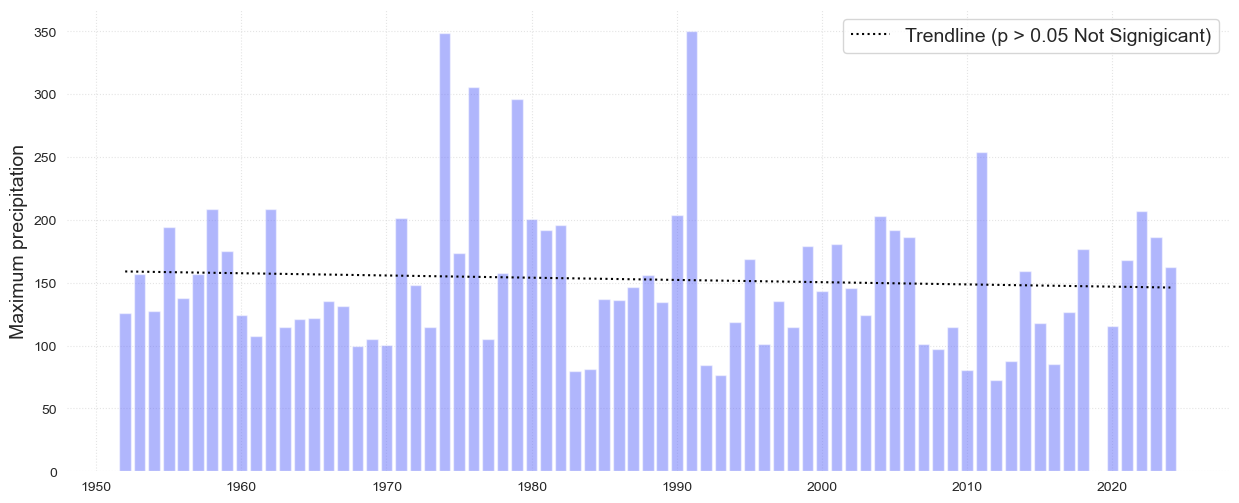

In [15]:
plot_bar_probs(x = datag.index.year, y = datag.PRCP.values, trendline=True, figsize = (15, 6),
                y_label = 'Maximum precipitation')

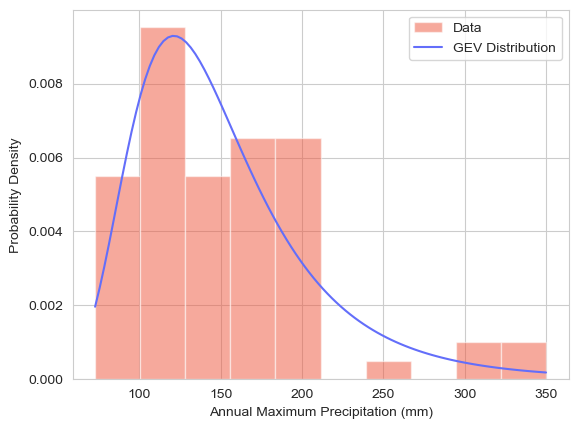

In [16]:
from scipy.stats import genextreme
import matplotlib.pyplot as plt
# Fit the data to GEV distribution
params = genextreme.fit(datag)

# Plot the histogram
plt.hist(datag, bins=10, density=True, alpha=0.5, label='Data', color = get_df_col()[1])

# Generate the GEV distribution using the fitted parameters
gev_dist = genextreme(*params)

# Plot the GEV distribution
x = np.linspace(datag.min(), datag.max(), 100)
plt.plot(x, gev_dist.pdf(x), '-', color = get_df_col()[0], label='GEV Distribution')

plt.xlabel('Annual Maximum Precipitation (mm)')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


In [17]:
nsims = 1000
years_sim = 100  # years of precipitation to simulate

# use simulated GEVs
var_sim = np.zeros([years_sim, nsims])*np.nan  # initialize output numpy array
for sim in range(nsims):
    
    var_sim[:, sim] = gev_dist.rvs(size=years_sim)

var_sim = var_sim.T 
time_sim = np.arange('1970-10-01', '{0}-10-01'.format(1970+years_sim), dtype='datetime64[Y]')
 

In [18]:
# aux func for calculating rp time
def t_rp(time_y):
    ny = len(time_y)
    return np.array([1/(1-(n/(ny+1))) for n in np.arange(1,ny+1)])

# historical rp time and sorted annual maxima
trp_hist = t_rp(np.unique(data.index.year))
trp_hist_val = np.sort(data['PRCP'].groupby(data.index.year).max().values)

# simulation rp time and sorted annual maxima
trp_sim = t_rp(time_sim)
trp_sim_val = np.sort(var_sim)

# calculate simulation maxima percentiles
p95 = np.percentile(trp_sim_val, 100-5/2.0, axis=0,)
p50 = np.percentile(trp_sim_val, 50, axis=0,)
p05 = np.percentile(trp_sim_val, 5/2.0, axis=0,)

In [19]:
import plotly.graph_objects as go

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=trp_sim, y=p95, mode='lines', name='P95', marker_color='mediumturquoise'))
fig.add_trace(go.Scatter(x=trp_sim, y=p05, mode='lines', name='P05', marker_color='mediumturquoise',  fill='tonexty', fillcolor='rgba(0, 181, 204, 0.10)'))
fig.add_trace(go.Scatter(x=trp_sim, y=p50, mode='lines', name='P50', marker_color='black'))
fig.add_trace(go.Scatter(x=trp_hist, y=trp_hist_val, mode='markers', name='Hist', marker_color='red'))


fig.update_xaxes(type="log")
fig.update_layout(    
    xaxis_title = "Return Period (years)",
    yaxis_title = "Precipitation (mm/d)",
    title = 'Annual Maxima',
    width=800, height=500
)
fig.show()